          freq     amp
0   161.430394  1360.9
1    38.582176  1321.8
2   181.520023  1241.7
3   144.127060   931.5
4   149.196076   758.4
5   200.289850   616.1
6   147.723831   533.5
7    22.397801   370.1
8     4.006829   341.4
9   164.390440   332.7
10  227.301840   315.5
11  143.698345   299.8
12    6.661921   285.8
13   20.648843   272.0
14   10.928472   267.8
15  176.234329   257.2
16   17.788773   240.3
17   39.411458   235.3
18    5.807523   228.9
19  174.852315   220.1
20   37.569213   206.3
21  198.765278   201.9
22  134.348727   194.7
23    4.736921   191.5
24   16.724190   179.8
25  173.427315   160.9
26    5.315625   148.7
27  201.758565   146.9
28   11.965856   143.7
29  184.067130   131.3


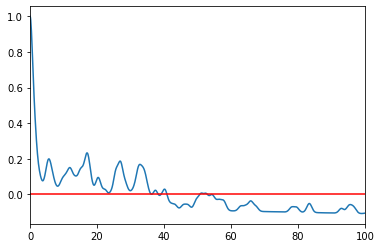

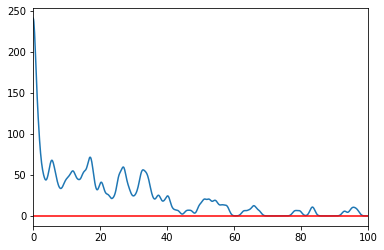

In [29]:
import logging

from scipy.stats import binned_statistic

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri

import glob
import numpy as np
import pandas as pd

import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import time
#from scipy.signal import argrelextrema
from scipy import signal
import decimal as dc
from astropy.stats import bayesian_blocks


log = logging.getLogger(__name__)
"""
One all evolution tracks are generated; we use the next commands to generate a splitted
batch of them, in order to be processed by tf.Datasets

# all files to one file 
find . -name "*.log" -exec cat '{}' ';' > allevolution_tracks.out

# Create dir and split big file
mkdir part
mv allevolution_tracks.out parts
cd parts

# split big file into multiple ones, using 1000 lines per file
split -l 1000 allevolution_tracks.out
rm allevolution_tracks.out

"""

def autocor(freqs):
    
    #IMPORTANT: ASSUMING 
    #freqs = frequencies (in muHz)
    #sig = peak's width (Rayleigh resolution)
    #f_max = maximum frequency of the amplitude spectrum
    #freqf = maximum value of the autocorrelation
    
    sig = 0.5 #muHz
#     d = dc.Decimal(str(sig))
#     dec = abs(d.as_tuple().exponent) #Decimal part of sig
#     fac = 10**dec #multiplicative factor
#     #Observed frequencies are between 0 and highest frequency value plus 100 muHz, to be sure.
#     #Integer is needed to create the matrix of zeros
#     #f_max = 1000 #muHz (observed frequencies are between 0 and 1000 muHz)
#     f_max = int(np.max(freqs)+100) #muHz
    freqf = 200 #muHz
    
    #gauss = signal.gaussian(f_max*fac,sig*fac) #Generic gaussian function
    
#     fc = np.zeros(f_max*fac) #Initializing sum of gaussians
    
#     for f in freqs:
#         fc += 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*((np.linspace(0,f_max,f_max*fac)-f)/sig)**2) #Sum of a gaussian function for each frequency
    
    #Calling the gaussian_periodogram function with amplitudes = 1
    fc,base_fc,fac = gaussian_periodogram(freqs,np.ones(len(freqs)),sig)
    
    #for f in freqs:
    #    if ( f < len(gauss)/2 ): #If the frequency is in the lower-middle part of the gaussian function
    #        fc += np.append(gauss[int(len(gauss)/2-f*fac):len(gauss)],gauss[0:int(len(gauss)/2-f*fac)]) #add gaussian to the function
    #    elif ( f > len(gauss)/2 ): #If the frequency is in the upper-middle part of the gaussian function
    #        fc += np.append(gauss[0:int(f*fac-len(gauss)/2)],gauss[0:len(gauss)-int(f*fac-len(gauss)/2)])
    #    elif ( f == len(gauss)/2 ): #If the frequency is exact in the middle part of the gaussian function
    #        fc += gauss
    
    result = np.correlate(fc,fc,mode='full')
    re = result[int(result.size/2):]
    
#    plt.figure()
#    plt.plot(np.linspace(0,f_max,f_max*fac),result[int(result.size/2):])    
    
    return re[:freqf*fac], np.linspace(0,freqf,len(re[:freqf*fac]))

def gaussian_periodogram(freqs, amplitudes=[], sig=0.5):
    """
    This function computes a periodogram with the gaussians of the frequencies.
    Warning: It will use the amplitudes in logarithmic scale.
    
    INPUT:
        freqs = frequencies in muHz
        amplitudes = amplitudes
        sig = sigma, peak's width, (Rayleigh) frequency resolution in muHz
        
    OUTPUT:
        fc = Gaussian function of N points in a line, with N = max(freqs)*factor.
             The factor indicates the "decimals" your vector has.
    """
    # IMPORTANT: ASSUMING
    # freqs = frequencies (in muHz)
    # sig = peak's width (Rayleigh resolution)
    # f_max = maximum frequency of the amplitude spectrum

    if np.size(amplitudes) == 0:
        amplitudes = np.ones(len(freqs))

    d = dc.Decimal(str(sig))
    dec = abs(d.as_tuple().exponent)  # Decimal part of sig
    fac = 10 ** dec  # multiplicative factor
    # Observed frequencies are between 0 and highest frequency value plus 100 muHz, to be sure.
    # Integer is needed to create the matrix of zeros
    # f_max = 1000 #muHz (observed frequencies are between 0 and 1000 muHz)
    f_max = int(np.max(freqs) + 100)  # muHz

    # gauss = signal.gaussian(f_max*fac,sig*fac) #Generic gaussian function

    fc = np.zeros(f_max * fac)  # Initializing sum of gaussians

    # We are going to scale the amplitude to not get negative numbers taking log
    d2 = dc.Decimal(str(np.min(amplitudes)))
    decimal = abs(d2.as_tuple().exponent)
    # Checking if scale is 1 (amplitudes = integers)
    if decimal == 0:
        scale = 10  # This is to avoid values of 0 when amplitude <= 1
    elif np.min(amplitudes) <= 1:
        scale = 10 ** decimal  # This is to avoid values of 0 when amplitude <= 1
    else:
        scale = 1

    for f in freqs:
        fc += (
            np.log10(float(scale * amplitudes[freqs == f]))
            / (sig * np.sqrt(2 * np.pi))
            * np.exp(-0.5 * ((np.linspace(0, f_max, f_max * fac) - f) / sig) ** 2)
        )  # Sum of a gaussian function for each frequency in arbitrary units

    base_fc = np.linspace(
        0, f_max, len(fc)
    )  # This is the base (x) vector of the function fc

    # Testing the resulting function
    #     figure_per = plt.figure()
    #     figure_per = plt.plot(base_fc,fc)

    return fc, base_fc, fac


input_resolution = 0.25
input_bins = np.arange(-1, 101, input_resolution)
for file in ["/home/roberto/Projects/NN-Asteroseismology/astronn/data/deltascuti/raw/KIC10080943.lis"]:
    log.info("Processing frequencies and amplitudes os star %s" % file)
    # read frequency of a given star
    df = pd.read_csv(
        file, header=None, index_col=False, names=["freq", "amp"], sep=" "
    )
    df = df.sort_values(by=['amp'], ascending=False)

    # Check for NaN values
    if df.isnull().values.any():
        log.error("Some malformated value in file %s" % file)
        raise Exception("Some malformated value in file %s" % file)
    # process first N frequencies
    variable_stars = importr("variableStars")
    pandas2ri.activate()
    _res = variable_stars.process(
        frequency=df[["freq"]].values,
        amplitude=df[["amp"]].values,
        filter="uniform",
        gRegimen=58,
        numFrequencies=30,
        maxDnu=1,
        minDnu=15,
        dnuGuessError=False,
        debug=False,
        processFirstRangeOnly=30,
    )
    # Get first group of processed frequencies
    first_proccesed_freq_name = _res.rx2["fresAmps"].names[0]
    # All channel is binned respect the input_resolution
    dft = binned_statistic(
        np.stack(
            _res.rx2["fresAmps"]
            .rx2[str(first_proccesed_freq_name)]
            .rx2["fInv"],
            axis=-1,
        )[0],
        np.stack(
            _res.rx2["fresAmps"].rx2[str(first_proccesed_freq_name)].rx2["b"],
            axis=-1,
        )[0],
        statistic="max",
        bins=input_bins,
    )
    hd = binned_statistic(
        np.stack(
            _res.rx2["diffHistogram"].rx2["histogram"].rx2["bins"], axis=-1
        )[0],
        np.stack(
            _res.rx2["diffHistogram"].rx2["histogram"].rx2["values"], axis=-1
        )[0],
        statistic="max",
        bins=input_bins,
    )
    ac = binned_statistic(
        np.stack(_res.rx2["crossCorrelation"].rx2["index"], axis=-1)[0],
        np.stack(_res.rx2["crossCorrelation"].rx2["autocorre"], axis=-1)[0],
        statistic="max",
        bins=input_bins,
    )

df["freq"] =df["freq"] /0.0864
#fc,base_fc,fac = gaussian_periodogram(df.head(30)["freq"], df.head(30)[["amp"]].values)
print(df.head(30))
acor_fc, acor_x = autocor(df.head(30)["freq"])

plt.plot(np.stack(_res.rx2["crossCorrelation"].rx2["index"], axis=-1)[0],
        np.stack(_res.rx2["crossCorrelation"].rx2["autocorre"], axis=-1)[0],)
plt.xlim(0, 100)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()
#plt.plot(ac[1][:-1], ac[0])
#plt.xlim(0, 100)
#plt.show()
plt.plot(acor_x, acor_fc)
plt.xlim(0, 100)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()